### Imports and Helper Functions

In [1]:
# Python standard library
import os
from pathlib import Path
import pickle
import copy

# Computation
import numpy as np

# Visualization
from tqdm import tqdm
from matplotlib import colors
import matplotlib.pyplot as plt
from skimage.morphology import dilation, disk
from skimage.segmentation import find_boundaries

# Segmentation
import sis

In [2]:
%matplotlib inline

In [41]:
# Helper function for plotting
def get_cell_cmap(seg_spot_table, bg_color: str|None = None, remove_negatives: bool = True):
    # Create colormap for cell ids
    cell_colors = seg_spot_table.cell_palette(seg_spot_table.cell_ids)

    if remove_negatives:
        # Remove the negative values in cell_palette, which can throw off visualization
        cell_colors = {cell: color for cell, color in cell_colors.items() if cell in seg_spot_table.unique_cell_ids}

    if bg_color is not None:
        cell_colors[0] = colors.to_rgba('black')
        cell_colors[-1] = colors.to_rgba('black')

    cell_cmap = colors.ListedColormap(dict(sorted(cell_colors.items())).values())

    return cell_cmap

### Loading an experiment

The test data cannot be uploaded to github since they are too large, so you will have to download them from the brain image library using the `download_test_files.sh` script   

```
$ bash download_test_files.sh
```

#### Merscope

In [4]:
# The downloadable data is a MERSCOPE experiment result
expt_path = Path(os.path.abspath('')) / "test_data/"
image_path = expt_path / 'images/'
csv_file = expt_path / 'detected_transcripts.csv'
cache_file = expt_path / 'detected_transcripts.csv.npz'

st = sis.SpotTable.load_merscope(csv_file=csv_file, cache_file=cache_file, image_path=image_path)

Loading csv..
Recompressing to npz..


#### Xenium (data not provided)

In [ ]:
# expt_path = Path(os.path.abspath('')) / "test_data/"
# image_path = expt_path / 'morphology.ome.tif'
# transcript_file = expt_path / 'transcripts.parquet'
# cache_file = expt_path / 'detected_transcripts.npz'

# st = sis.SpotTable.load_xenium(cls, transcript_file=transcript_file, cache_file=cache_file, image_path=image_path)

#### Stereoseq (data not provided)

In [ ]:
# expt_path = Path(os.path.abspath('')) / "test_data/"
# image_file = list(expt_path.glob('*regist.tif'))[0]
# gem_file = list(expt_path.rglob('*tissue.gem.gz'))[0]
# cache_file = list(expt_path.rglob('*detected_transcripts.npz'))[0]

# st = sis.SpotTable.load_stereoseq(cls, gem_file=gem_file, cache_file=cache_file, image_file=image_file, skiprows=7, image_channel='nuclear'):

### Pick a small tile to test on

We will use a region of high cell density to demonstrate the improvement of the custom model over pretrained Cellpose models.

In [14]:
subrgn = ((2000, 2200), (1400, 1600))
sub_st = st.get_subregion(xlim=subrgn[0], ylim=subrgn[1])

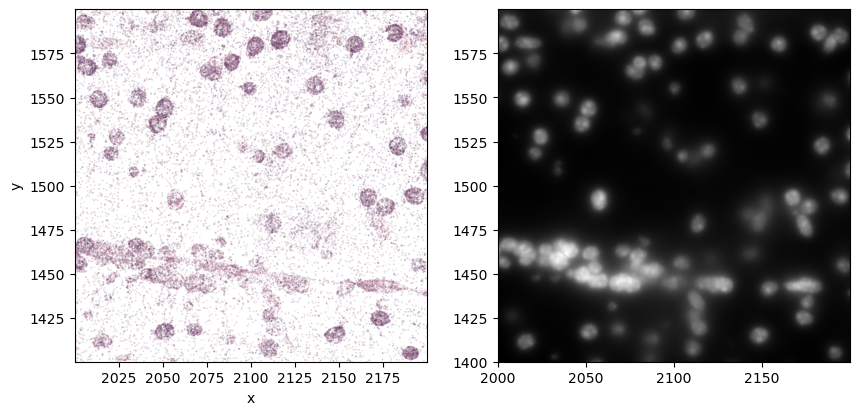

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sub_st.scatter_plot(ax=ax[0])
sub_st.get_image(channel='DAPI').show(ax=ax[1], frame='mean', cmap='gray')

### Choose a custom Cellpe model for segmentation
#### Currently available finetuned models:
 - CP_20240611_mousedev: cyto model for total_mrna + nuclei, finetuned on 24 MERSCOPE images from 24 different brain sections (6 P0, 6 P4, 3 P28_M, 3 P28_F, 3 P20_M, 3 P20_F)
 - cellpose_20240712_macaque_stereoseq: Not currently included

In [18]:
path_to_model = str(Path(os.path.abspath('')) / "models/CP_20240611_mousedev")
# path_to_model = str(Path(os.path.abspath('')) / "models/cellpose_20240712_macaque_stereoseq")

### Use custom model to segment a single (2D) slice

Note: if running segmentation on a two channel image, you must specify the frames for both channels

In [19]:
seg_opts_2d = {
                'region': None,
                'cellpose_model': path_to_model, # path (to custom model) or string (for pretrained model, e.g. 'cyto2')
                'cellpose_gpu': 'auto',
                'px_size': 0.108,          # um / px
                'cell_dia': 10,            # um (or None)
                'z_plane_thickness': 1.5,  # um
                'images': {
                    'nuclei': {'channel': 'DAPI', 'frames': 3},
                    'cyto': {'channel': 'total_mrna', 'n_planes': 7, 'frames': 3}
                }, 
                'cellpose_options': {
                    'batch_size': 8,
                }
              }

seg_custom_2d = sis.segmentation.CellposeSegmentationMethod(seg_opts_2d)
result_custom_2d = seg_custom_2d.run(sub_st)

>>>> loading model /allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/jacobquon/sawghack/spots-in-space/models/CP_20240611_mousedev
** TORCH CUDA version installed and working. **
>>>> using GPU
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
>>>> model diam_labels =  99.794 (mean diameter of training ROIs)


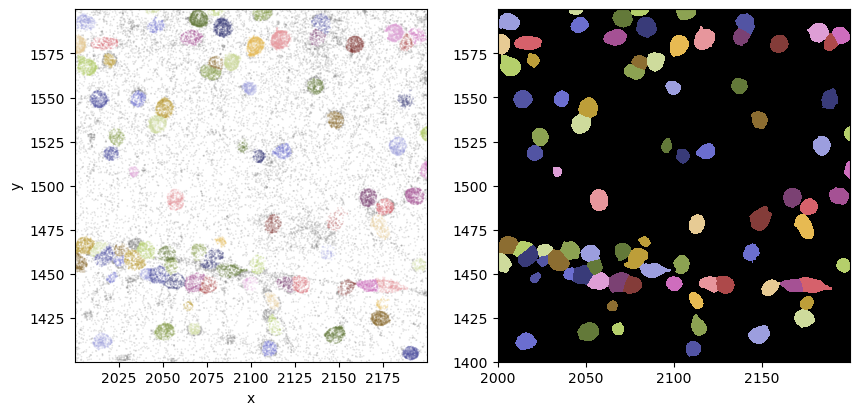

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Create colormap for cell ids
cmap_custom_2d = get_cell_cmap(result_custom_2d.spot_table(), bg_color='black')

result_custom_2d.spot_table().scatter_plot(ax=ax[0], color='cell_ids')
result_custom_2d.mask_image.show(ax[1], cmap=cmap_custom_2d, interpolation='None')

### Compare to results of a pretrained Cellpose model

In [43]:
# Use all the same options except for the model
seg_opts_cyto = copy.deepcopy(seg_opts_2d)
seg_opts_cyto['cellpose_model'] = 'cyto2'

seg_cyto_2d = sis.segmentation.CellposeSegmentationMethod(seg_opts_cyto)
result_cyto_2d = seg_cyto_2d.run(sub_st)

** TORCH CUDA version installed and working. **
>>>> using GPU
>> cyto2 << model set to be used
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
channels set to [1, 2]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 1.17 sec


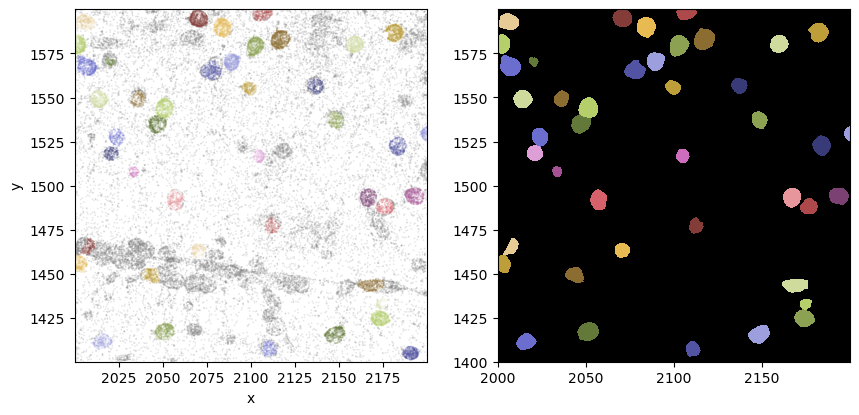

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Create colormap for cell ids
cmap_cyto_2d = get_cell_cmap(result_cyto_2d.spot_table(), bg_color='black')

result_cyto_2d.spot_table().scatter_plot(ax=ax[0], color='cell_ids')
result_cyto_2d.mask_image.show(ax[1], cmap=cmap_cyto_2d, interpolation='None')

#### Side-by-side comparison to two models

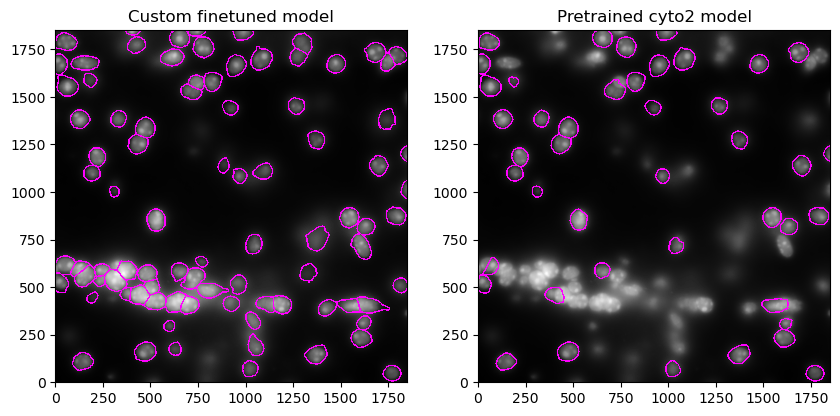

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

cmap_transparent0 = colors.ListedColormap(['none', 'magenta'])

cyto_outlines = dilation(find_boundaries(result_cyto_2d.mask_image.get_data()[0, ...]), footprint=disk(3))
custom_outlines = dilation(find_boundaries(result_custom_2d.mask_image.get_data()[0, ...]), footprint=disk(3))

ax[0].imshow(sub_st.get_image(channel='DAPI').get_frames(3).get_data()[0, ...], cmap='gray')
ax[0].imshow(custom_outlines, cmap=cmap_transparent0, interpolation='nearest')
ax[0].invert_yaxis()
ax[0].set_title('Custom finetuned model')

ax[1].imshow(sub_st.get_image(channel='DAPI').get_frames(3).get_data()[0, ...], cmap='gray')
ax[1].imshow(cyto_outlines, cmap=cmap_transparent0, interpolation='nearest')
ax[1].invert_yaxis()
ax[1].set_title('Pretrained cyto2 model')

plt.show()

### Run custom Cellpose on a 3D stack

To run 3D segmentation, omit the frame argument.

Note: 3D Cellpose segmentation can be very slow without GPU access.

In [46]:
seg_opts_3d = {
                'region': None,
                'cellpose_model': path_to_model,
                'cellpose_gpu': 'auto',
                'px_size': 0.108,          # um / px
                'cell_dia': 10,            # um (or None)
                'z_plane_thickness': 1.5,  # um
                'images': { # The frame options in each of the image dictionaries
                    'nuclei': {'channel': 'DAPI'},
                    'cyto': {'channel': 'total_mrna', 'n_planes': 7} 
                }, 
                'cellpose_options': {
                    'batch_size': 8,
                    'min_size': 5000 # We use this to remove 3D segmentation artifacts
                }
              }

seg_custom_3d = sis.segmentation.CellposeSegmentationMethod(seg_opts_3d)
result_custom_3d = seg_custom_3d.run(sub_st)

>>>> loading model /allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/jacobquon/sawghack/spots-in-space/models/CP_20240611_mousedev
** TORCH CUDA version installed and working. **
>>>> using GPU
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
>>>> model diam_labels =  99.794 (mean diameter of training ROIs)
multi-stack tiff read in as having 7 planes 3 channels
running YX: 7 planes of size (1852, 1852)
100%|##########| 4/4 [00:01<00:00,  3.85it/s]
running ZY: 1852 planes of size (7, 1852)
100%|##########| 232/232 [00:09<00:00, 24.80it/s]
running ZX: 1852 planes of size (7, 1852)
100%|##########| 232/232 [00:09<00:00, 25.01it/s]
network run in 22.71s
masks created in 36.73s


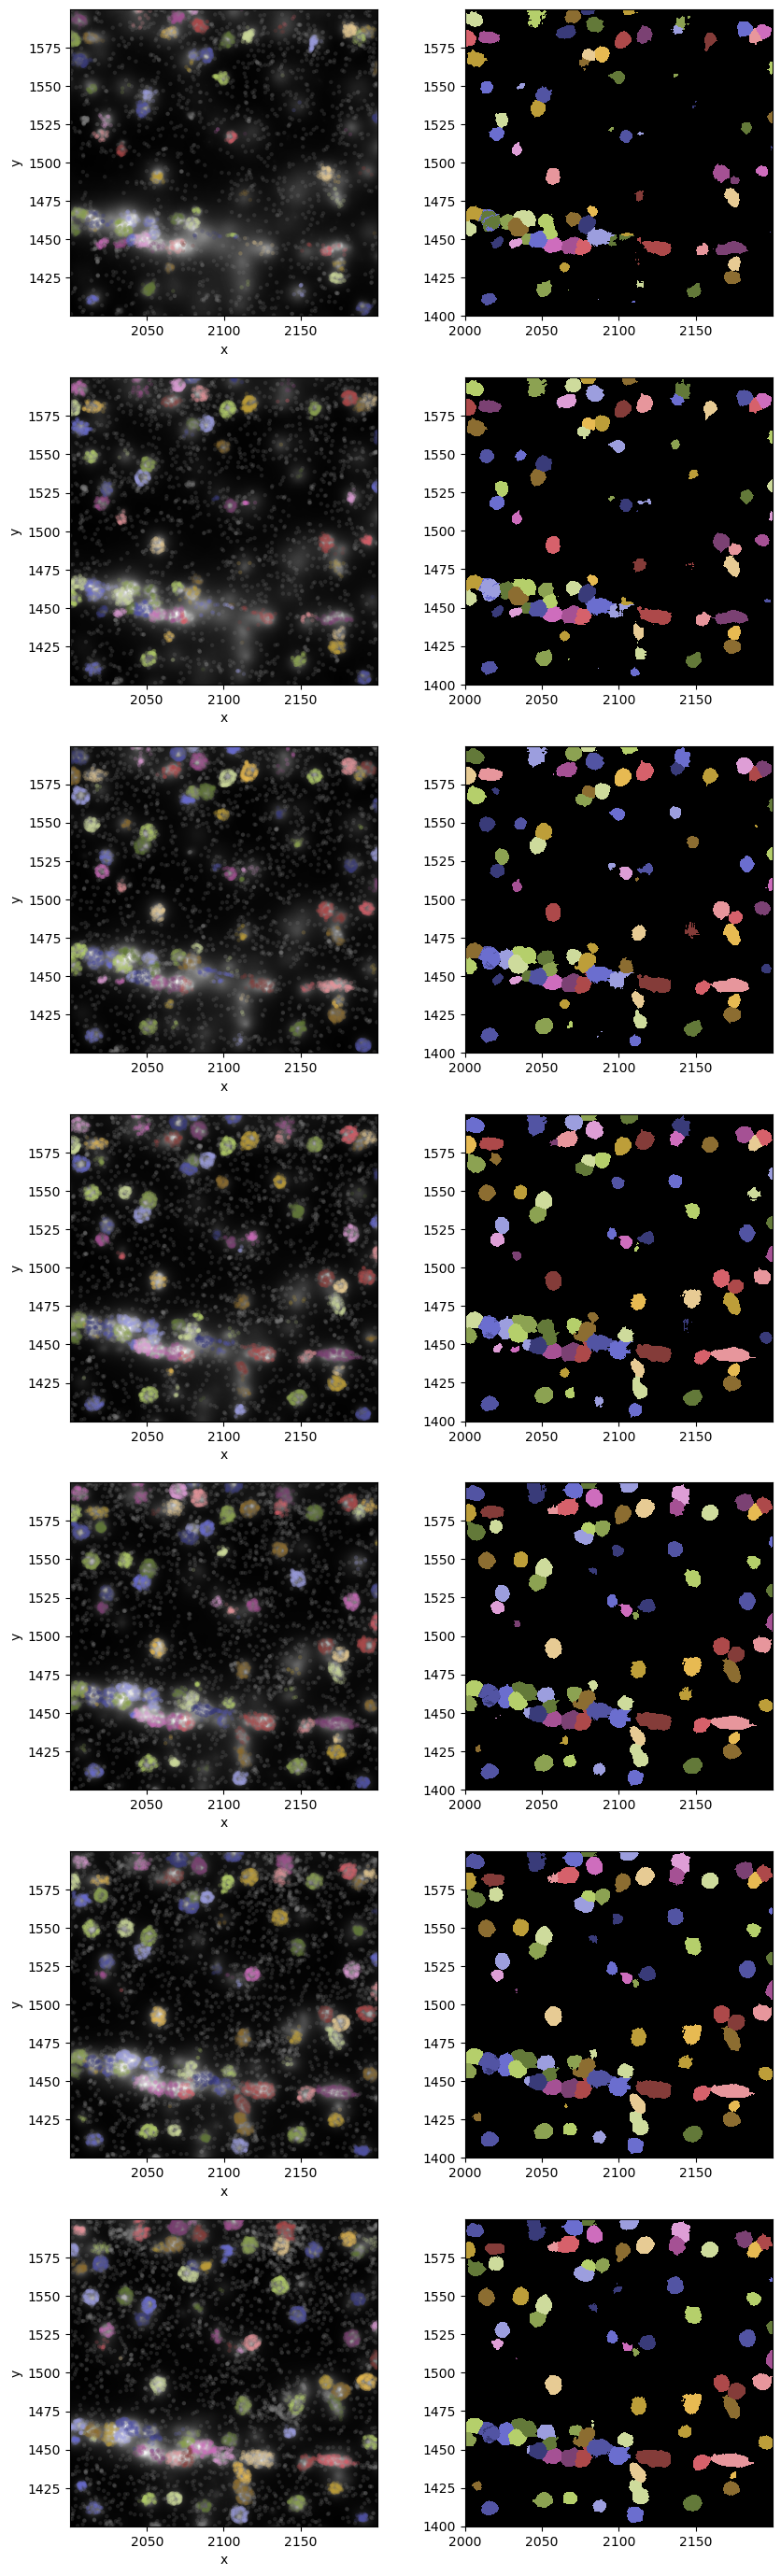

In [47]:
img = sub_st.get_image(channel='DAPI')
n_planes = img.shape[0]

fig, ax = plt.subplots(n_planes, 2, figsize=(10, 5*n_planes))

# Create colormap for cell ids
cmap_custom_3d = get_cell_cmap(result_custom_3d.spot_table(), bg_color='black')

for i in range(n_planes):
    mask = sub_st.z == i
    result_custom_3d.spot_table()[mask].scatter_plot(ax=ax[i, 0], color='cell_ids', size=10)
    
    img_layer = img.get_frames(i)
    img_layer.show(ax[i, 0], cmap='gray')
    mask_layer = result_custom_3d.mask_image.get_frames(i)
    mask_layer.show(ax[i, 1], cmap=cmap_custom_3d, interpolation='None')

### Run custom Cellpose on a whole section using a hpc

This is the recommended method to run segmentation. It does require a high performance computing cluster with SLURM, but it takes care of everything automatically, including loading the data, distributing segmentation, distributing cell polygons calculation, creating a cell by gene table, and cleaning up any intermediate files.

Note that this method cannot work without tiling the section, so your input section must be larger than your tiles (these default to 200um, though we have been using 350um). Thus for smaller regions (like the previous examples) you must do the segmentation steps manually. Including calculating cell polygons and creating anndata. These steps are detailed at the bottom of the notebook for reference

### Using the MerscopeSegmentationPipeline class

In [ ]:
# Define the path to the model you want to segment with
# This can also be one of ['cyto', 'cyto2', 'nuclei']
path_to_model = str(Path(os.path.abspath('')) / "models/CP_20240611_mousedev")

# Define the input and output data
expt_path = Path(os.path.abspath('')) / "test_data/"
output_dir = Path('PATH_TO_OUTPUT_DIRECTORY')
csv_file = expt_path / 'detected_transcripts.csv'
cache_file = expt_path / 'detected_transcripts.csv.npz'
image_path = expt_path / 'images/'

# Pick a subregion to segment on
# The subregion to segment. Set to a string, e.g. 'DAPI', to segment the 
# full region bounded by the associated image channel. To segment a 
# smaller region, set to a tuple corresponding to a bounding box
subrgn = ((2000, 2665), (2000, 2665)) # alternatively: 'DAPI' 
seg_method= sis.segmentation.CellposeSegmentationMethod

# Define the segmentation options as we did for the small region examples above
seg_opts = {
    'cellpose_model': path_to_model,
    'cellpose_gpu': 'auto',
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um
    'z_plane_thickness': 1.5,  # um
    'images': {
        'cyto': {'channel': 'total_mrna', 'n_planes': 7},
        'nuclei': {'channel': 'DAPI', }
    },
    'cellpose_options': {
        'batch_size': 8, 'min_size': 5000
    },
    }

# Define options for the SLURM jobs that will be submitted by the program
seg_hpc_opts = {
             # This should be the path to the environment you are using to run this notebook
            'conda_env': 'PATH_TO_CONDA_ENV_FOR_SEGMENTATION', 
            'hpc_host': 'localhost',
            'time': '01:15:00',
            'mem': '30G'}
polygon_hpc_opts = {
            'num_jobs': 10,
            'conda_env': 'PATH_TO_CONDA_ENV_FOR_SEGMENTATION',
            'hpc_host': 'localhost',
            'time': '01:15:00'}

In [ ]:
seg_pipeline = sis.segmentation.MerscopeSegmentationPipeline(csv_file,
                                                             image_path,
                                                             output_dir,
                                                             cache_file,
                                                             subrgn,
                                                             seg_method,
                                                             seg_opts,
                                                             seg_hpc_opts=seg_hpc_opts,
                                                             polygon_hpc_opts=polygon_hpc_opts)

In [ ]:
seg_pipeline.run(x_format='sparse', overwrite=True, clean_up=True, tile_size=350, min_transcripts=1000)

### Using the XeniumSegmentationPipeline and StereoseqSegmentationPipeline classes

Segmentation of alternative datatypes is quite similar to Merscope, with a few exceptions detailed below in comments

In [ ]:
path_to_model = str(Path(os.path.abspath('')) / "models/CP_20240611_mousedev")

expt_path = Path('PATH_TO_MERSCOPE_EXPERIMENT')
output_dir = Path('PATH_TO_OUTPUT_DIRECTORY')
dt_file = expt_path / 'transcripts.parquet'
dt_cache = expt_path / 'detected_transcripts.csv.npz'
image_path = expt_path / 'morphology.ome.tif'

subrgn = ((2000, 2665), (2000, 2665))
seg_method= sis.segmentation.CellposeSegmentationMethod

seg_opts = {
    'cellpose_model': path_to_model,
    'cellpose_gpu': 'auto',
    'px_size': 0.2125, # Different pixel size
    'cell_dia': 10,
    'z_plane_thickness': 3, # Different z-plane thickness
    'detect_z_planes': 0.01, # Xenium output often contains empty z-planes which wastes compute, we therefore only run segmentation on z-planes with >=1% of total transcripts
    'duplistack': True, # There is often a low number of z-planes after removing empties. Thus 3d segmentation performs poorly. To combat this, we interleave copies of z-planes to artificially increase the number of planes to segment on. These are later removed.
    'images': {
        'cyto': {'channel': 'total_mrna', 'n_planes': 7, 'gauss_kernel': (0.25, 3, 3), 'median_kernel': (2, 10, 10)}, # we define alternative total_mrna kernels which work better with xenium data
        'nuclei': {'channel': 'DAPI', }
    },
    'cellpose_options': {
        'batch_size': 8, 'min_size': 600 # Different min_size (scales with px size)
    },
    }

seg_hpc_opts = {
            'conda_env': 'PATH_TO_CONDA_ENV_FOR_SEGMENTATION', 
            'hpc_host': 'localhost',
            'time': '01:15:00',
            'mem': '30G'}
polygon_hpc_opts = {
            'num_jobs': 10,
            'conda_env': 'PATH_TO_CONDA_ENV_FOR_SEGMENTATION',
            'hpc_host': 'localhost',
            'time': '01:15:00'}

seg_pipeline = sis.segmentation.XeniumSegmentationPipeline(dt_file,
                                                           image_path, 
                                                           output_dir, 
                                                           dt_cache, 
                                                           subrgn, 
                                                           seg_method, 
                                                           seg_opts, 
                                                           seg_hpc_opts=seg_hpc_opts, 
                                                           polygon_hpc_opts=polygon_hpc_opts, 
                                                           cache_image=False)

seg_pipeline.run(x_format='sparse', overwrite=True, clean_up=True, tile_size=350, min_transcripts=1000)

In [ ]:
path_to_model = str(Path(os.path.abspath('')) / "models/cellpose_20240712_macaque_stereoseq") # We have to use a different model

expt_path = Path('PATH_TO_MERSCOPE_EXPERIMENT')
output_dir = Path('PATH_TO_OUTPUT_DIRECTORY')
image_path = list(expt_path.glob('*regist.tif'))[0]
dt_file = list(expt_path.rglob('*tissue.gem.gz'))[0]
dt_cache = list(expt_path.rglob('*detected_transcripts.npz'))[0]

subrgn = ((2000, 2665), (2000, 2665))
seg_method= sis.segmentation.CellposeSegmentationMethod

seg_opts = {
    'cellpose_model': path_to_model,
    'cellpose_gpu': 'auto',
    'px_size': 0.5, # Different pixel size
    'cell_dia': 10, 
    'z_plane_thickness': 1.5,
    'images': {
        'cyto': {'channel': 'total_mrna',
                 'n_planes': 1, # We only segment in 2d for stereoseq
                 'frames': 0, # Just the first frame since we only have 1 z-plane
                 'gauss_kernel': (1, 1, 1), # Different total_mrna gaussian kernel for stereoseq
                 'median_kernel': (1, 1, 1)},  # Different total_mrna median kernel for stereoseq
        'nuclei': {'channel': 'nuclear',
                   'frames': 0 # Only want to take frame 0 since we are only segmenting in 2D
                   }
    }, 
    'cellpose_options': {
        'batch_size': 8, # No min_size
    },
}

seg_hpc_opts = {
            'conda_env': 'PATH_TO_CONDA_ENV_FOR_SEGMENTATION', 
            'hpc_host': 'localhost',
            'time': '01:15:00',
            'mem': '30G'}
polygon_hpc_opts = {
            'num_jobs': 10,
            'conda_env': 'PATH_TO_CONDA_ENV_FOR_SEGMENTATION',
            'hpc_host': 'localhost',
            'time': '01:15:00'}

seg_pipeline = sis.segmentation.StereoSeqSegmentationPipeline(dt_file,
                                                              image_path,
                                                              output_dir,
                                                              dt_cache,
                                                              subrgn,
                                                              seg_method,
                                                              seg_opts,
                                                              seg_hpc_opts=seg_hpc_opts,
                                                              polygon_hpc_opts=polygon_hpc_opts)

seg_pipeline.run(x_format='sparse', overwrite=True, clean_up=True, tile_size=350, min_transcripts=1000)

### Steps of the SegmentationPipeline.run function

In [ ]:
x_format='sparse'   # Desired format for the cell by gene anndata X. Options: 'dense' or 'sparse'
prefix=''           # The string to prepend to all cell labels
suffix=''           # The string to append to all cell labels
overwrite=True      # Whether to allow overwriting of output files. Default False.
clean_up='all_ints' # Whether or not to clean up intermediate files after segmentation. Accepts: 'all_ints', 'seg_ints', 'polygon_ints', 'none', True, False, None
tile_size=200       # The maximum size of tiles to segment. Default 200. Increasing this parameter may also require increasing time and/or memory limits in seg_hpc_opts.
min_transcripts=0   # Minimum number of transcripts in a tile to be considered for segmentation
rerun=True          # If enabled, SegmentationPipeline will attempt to automatically rerun jobs that failed. Doubling memory or time when jobs fail due to the respective reasons

# update and save run metadata in case user updated parameters
seg_pipeline.update_metadata()
seg_pipeline.save_metadata(overwrite)

# load the raw spot table corresponding to the segmentation region
seg_pipeline.load_raw_spot_table()

# Tile the raw spot table
tiles, regions = seg_pipeline.tile_seg_region(overwrite=overwrite, max_tile_size=tile_size, min_transcripts=min_transcripts)

# Create dictionary containing segmentation run instructions
seg_run_spec = seg_pipeline.get_seg_run_spec(regions=regions, overwrite=overwrite, result_files=False if clean_up else True)

# SLURM HPC SUBMISSION. ALTERNATIVE RUN METHODS WILL NEED TO REPLACE THESE LINES
seg_pipeline.seg_jobs = seg_pipeline.submit_jobs('segmentation', seg_run_spec, overwrite)
if rerun:
    seg_pipeline.seg_jobs = seg_pipeline.rerun_failed_jobs('segmentation_rerun', seg_pipeline.seg_jobs, seg_run_spec)
cell_ids, merge_results, seg_skipped = seg_pipeline.merge_segmented_tiles(run_spec=seg_run_spec, tiles=tiles, detect_z_planes=seg_pipeline.seg_opts.get('detect_z_planes', None), overwrite=overwrite)

# Create dictionary containing polygon generation instructions
polygon_run_spec = seg_pipeline.get_polygon_run_spec(overwrite)

# SLURM HPC SUBMISSION. ALTERNATIVE RUN METHODS WILL NEED TO REPLACE THESE LINES
seg_pipeline.polygon_jobs = seg_pipeline.submit_jobs('cell_polygons', polygon_run_spec, overwrite)
if rerun:
    seg_pipeline.polygon_jobs = seg_pipeline.rerun_failed_jobs('cell_polygons_rerun', seg_pipeline.polygon_jobs, polygon_run_spec)
cell_polygons, cell_polygons_skipped = seg_pipeline.merge_cell_polygons(run_spec=polygon_run_spec, overwrite=overwrite)

# Create output cell-by-gene
cell_by_gene = seg_pipeline.create_cell_by_gene(x_format=x_format, prefix=prefix, suffix=suffix, overwrite=overwrite)

# Save the segmented spot table
seg_pipeline.save_seg_spot_table(overwrite=overwrite)

# Clean up the intermediate files
if clean_up:
    clean_up = 'all_ints' if clean_up == True else clean_up # If the user decides to input true we'll just set that to all ints
    seg_pipeline.clean_up(clean_up)